## Model Fitting-Model Evaluation-Predictions-----v1

X shape: (17258, 24, 21)
y shape: (17258, 12)


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        22,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,492 (95.67 KB)

 Trainable params: 24,492 (95.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0013 - val_loss: 1.1029e-04
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.1768e-05 - val_loss: 4.0096e-05
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 6.7064e-06 - val_loss: 2.4687e-05
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.6720e-06 - val_loss: 1.6566e-05
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.4353e-06 - val_loss: 1.4751e-05
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 5.3440e-06 - val_loss: 1.5852e-05
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.1582e-06 - val_loss: 1.6364e-05
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9638e-06 - val_loss: 1.5446e-05
Epoch 9/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.9851e-06 - val_loss: 1.4606e-05
Epoch 10/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9215e-06 - val_loss: 1.3508e-05
Epoch 11/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.0491e-06 - 

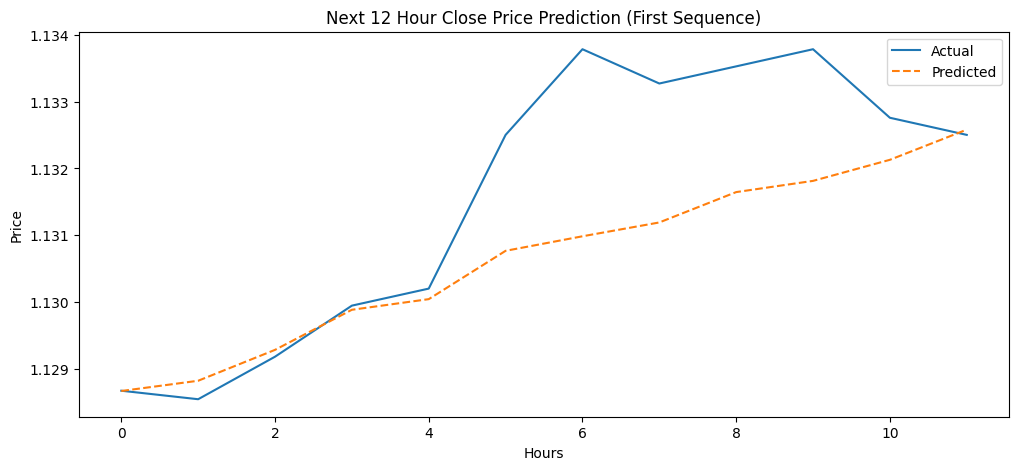

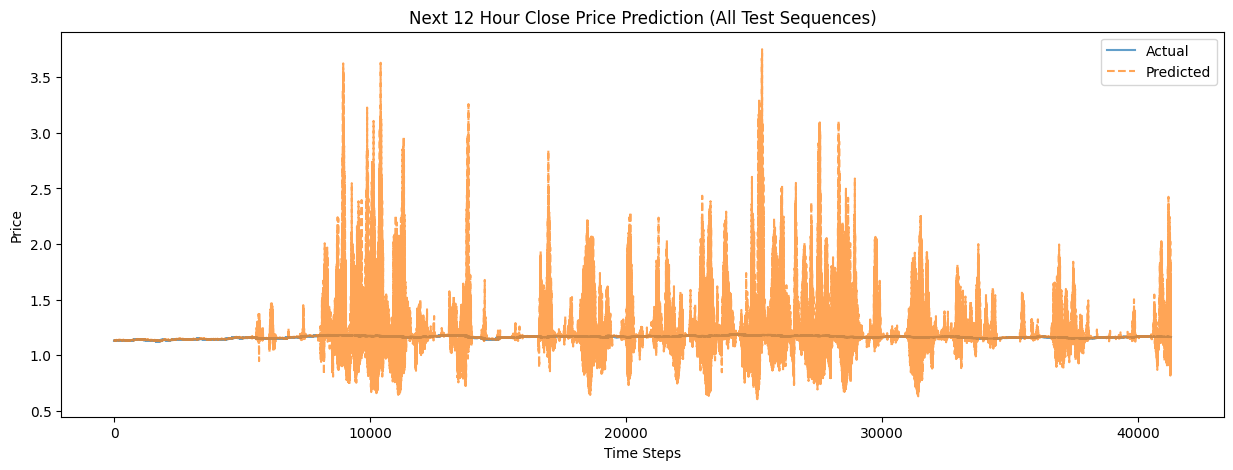

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------
# 1. LOAD DATA
# -------------------------
df = pd.read_csv("EURUSD=X_feature_data.csv", parse_dates=["Datetime"], index_col="Datetime")
# optional: if you want to drop IRD column that has NaNs
df = df.drop("interest_rate_differential", axis=1, errors="ignore")

# -------------------------
# 2. COMPUTE LOG RETURNS
# -------------------------
FORECAST = 12  # predict next 12 returns

# SAVE raw Close before any scaling/modification
df["Close_raw"] = df["Close"].copy()

# Create multi-step log-return targets (aligned so row t contains returns for t->t+1..t+FORECAST)
for i in range(1, FORECAST + 1):
    df[f"return_{i}h"] = np.log(df["Close"].shift(-i) / df["Close"])

# Drop rows with NaNs (these will be the last FORECAST rows)
df.dropna(inplace=True)

# -------------------------
# 3. FEATURES AND TARGETS
# -------------------------
target_cols = [f"return_{i}h" for i in range(1, FORECAST + 1)]

# Build feature list: everything except the target return columns and the raw price columns
# (we explicitly exclude "Close" and "Close_raw" from scaling / model features)
feature_cols = [c for c in df.columns if c not in target_cols and c not in ["Close", "Close_raw"]]

# Scale features only (do NOT scale returns or Close_raw)
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# -------------------------
# 4. CREATE SEQUENCES
# -------------------------
LOOKBACK = 24  # past 24 hours

def create_sequences(features, targets, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i:i+lookback])
        y.append(targets[i+lookback])
    return np.array(X), np.array(y)

X, y = create_sequences(df[feature_cols].values, df[target_cols].values, LOOKBACK)
print("X shape:", X.shape)  # (samples, LOOKBACK, features)
print("y shape:", y.shape)  # (samples, FORECAST)

# -------------------------
# 5. TRAIN/TEST SPLIT
# -------------------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------------
# 6. BUILD LSTM MODEL
# -------------------------
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(LOOKBACK, X.shape[2])),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(FORECAST)
])
model.compile(optimizer="adam", loss="mse")
model.summary()

# -------------------------
# 7. TRAIN MODEL
# -------------------------
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# -------------------------
# 8. PREDICT LOG RETURNS
# -------------------------
y_pred_log_returns = model.predict(X_test)
test_loss = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss)

# -------------------------
# 9. RECONSTRUCT PREDICTED PRICES (USING RAW CLOSE)
# -------------------------
# We must only keep sequences for which a full FORECAST-length actual slice exists.
# Number of usable sequences from X_test:
num_sequences = len(y_pred_log_returns) - FORECAST + 1
if num_sequences <= 0:
    raise ValueError("Not enough test sequences to produce full FORECAST-length actual slices. "
                     "Reduce LOOKBACK or FORECAST or use more data.")

# Starting price for each forecast: last known actual close *before* the forecast begins
last_close = df["Close_raw"].values[split + LOOKBACK - 1 : split + LOOKBACK - 1 + num_sequences]

pred_prices = []
for i in range(num_sequences):
    cum_returns = np.exp(np.cumsum(y_pred_log_returns[i]))  # cumulative factor for 1..FORECAST
    prices = last_close[i] * cum_returns
    pred_prices.append(prices)
pred_prices = np.array(pred_prices)  # shape = (num_sequences, FORECAST)

# -------------------------
# 10. ALIGN ACTUAL PRICES (USING RAW CLOSE)
# -------------------------
actual_prices = np.array([
    df["Close_raw"].values[split + LOOKBACK + i : split + LOOKBACK + i + FORECAST]
    for i in range(num_sequences)
])

# -------------------------
# 11. PRINT EXAMPLES
# -------------------------
print("Predicted prices (first sequence):", pred_prices[0])
print("Actual prices (first sequence):   ", actual_prices[0])

# Sanity: check positivity and shapes
print("min(last_close):", last_close.min(), "max(last_close):", last_close.max())
print("pred_prices.shape:", pred_prices.shape, "actual_prices.shape:", actual_prices.shape)

# -------------------------
# 12. PLOT FIRST SEQUENCE
# -------------------------
plt.figure(figsize=(12,5))
plt.plot(actual_prices[0], label="Actual")
plt.plot(pred_prices[0], label="Predicted", linestyle="--")
plt.title("Next 12 Hour Close Price Prediction (First Sequence)")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

# -------------------------
# 13. PLOT ALL PREDICTED VS ACTUAL (CONTINUOUS)
# -------------------------
pred_prices_cont = pred_prices.flatten()
actual_prices_cont = actual_prices.flatten()

plt.figure(figsize=(15,5))
plt.plot(actual_prices_cont, label="Actual", alpha=0.7)
plt.plot(pred_prices_cont, label="Predicted", linestyle="--", alpha=0.7)
plt.title("Next 12 Hour Close Price Prediction (All Test Sequences)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()


## Model Fitting-Model Evaluation-Predictions-----v2

2025-12-12 13:22:33.122320: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-12 13:22:54.530662: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-12 13:23:05.401452: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


X shape: (17234, 48, 23)
y shape: (17234, 12)

--- Training model with learning rate 0.001 ---



2025-12-12 13:23:07.862639: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


2025-12-12 13:23:08.234828: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 48704064 exceeds 10% of free system memory.


345/345 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - loss: 0.0106 - val_loss: 0.0035
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - loss: 0.0018 - val_loss: 8.1703e-04
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - loss: 4.3940e-04 - val_loss: 2.1094e-04
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - loss: 1.1707e-04 - val_loss: 6.4457e-05
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 3.6499e-05 - val_loss: 2.5799e-05
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - loss: 1.4498e-05 - val_loss: 1.4568e-05
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - loss: 7.9824e-06 - val_loss: 1.1128e-05
Epoch 8/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - loss: 5.9136e-06 - val_loss: 1.0154e-05
Epoch 9/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 30s 87ms/step - loss: 5.2449e-06 - val_loss: 9.5990e-06
Epoch 10/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - loss: 4.9943e-06 - val_loss: 9.5646e-06
Epoch 11/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - loss:

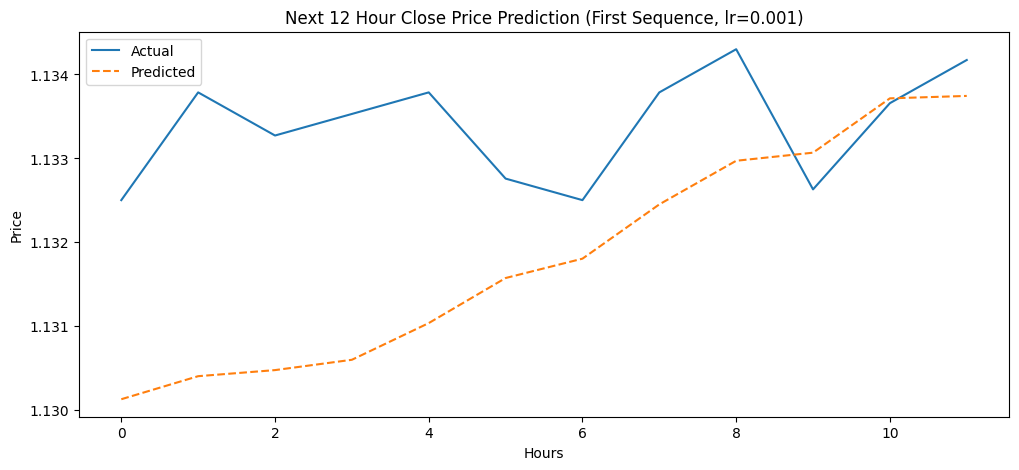

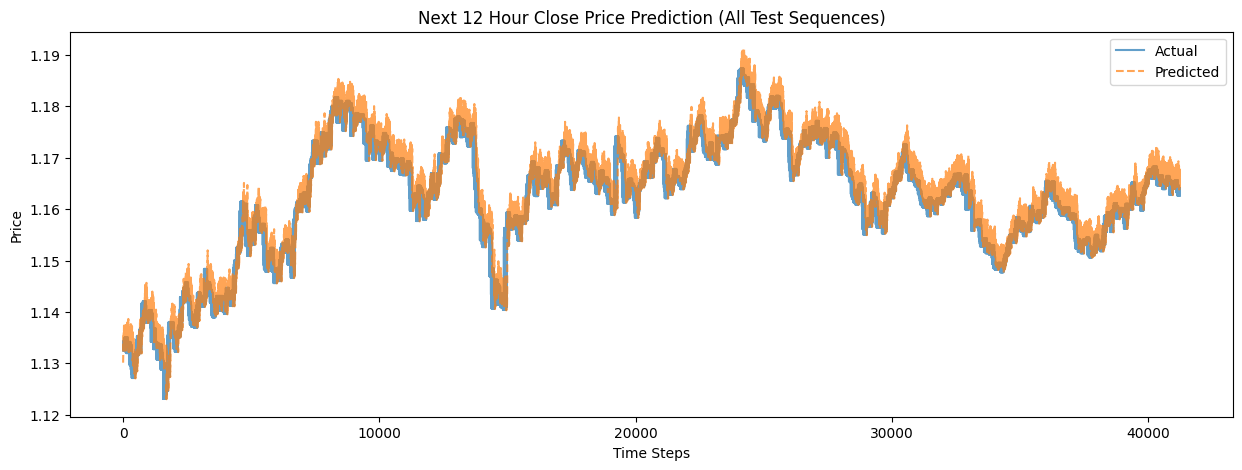

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# -------------------------
# 1. LOAD DATA
# -------------------------
df = pd.read_csv("EURUSD=X_feature_data.csv", parse_dates=["Datetime"], index_col="Datetime")
df = df.drop("interest_rate_differential", axis=1)  # currently has NaNs

# -------------------------
# 2. SAVE RAW CLOSE
# -------------------------
df["Close_raw"] = df["Close"].copy()

# -------------------------
# 3. COMPUTE LOG RETURNS
# -------------------------
FORECAST = 12  # predict next 12 returns
for i in range(1, FORECAST + 1):
    df[f"return_{i}h"] = np.log(df["Close"].shift(-i) / df["Close"])
df.dropna(inplace=True)  # remove last rows with NaNs

# -------------------------
# 4. FEATURES AND TARGETS
# -------------------------
target_cols = [f"return_{i}h" for i in range(1, FORECAST + 1)]
feature_cols = [c for c in df.columns if c not in target_cols]

# Scale features (do NOT scale returns or Close_raw!)
scaler = StandardScaler()
features_to_scale = [c for c in feature_cols if c != "Close_raw"]
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# -------------------------
# 5. CREATE SEQUENCES
# -------------------------
LOOKBACK = 48  # try longer sequences for better temporal context

def create_sequences(features, targets, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i:i+lookback])
        y.append(targets[i+lookback])
    return np.array(X), np.array(y)

X, y = create_sequences(df[feature_cols].values, df[target_cols].values, LOOKBACK)
print("X shape:", X.shape)
print("y shape:", y.shape)

# -------------------------
# 6. TRAIN/TEST SPLIT
# -------------------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------------
# 7. HYPERPARAMETER TUNING (LEARNING RATES) WITH REGULARIZATION
# -------------------------
learning_rates = [0.001]
results = {}

for lr in learning_rates:
    print(f"\n--- Training model with learning rate {lr} ---\n")
    
    # Build model with dropout and L2 regularization
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(LOOKBACK, X.shape[2]),
             dropout=0.3, recurrent_dropout=0.2, kernel_regularizer=l2(1e-4)),
        LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1,
             kernel_regularizer=l2(1e-4)),
        Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        Dense(FORECAST)
    ])
    
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse")
    
    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=1
    )
    
    # Predict
    y_pred_log_returns = model.predict(X_test)
    test_loss = model.evaluate(X_test, y_test)
    
    # Reconstruct prices using raw Close
    num_sequences = len(y_pred_log_returns) - FORECAST + 1
    last_close = df["Close_raw"].values[split + LOOKBACK - 1 : split + LOOKBACK - 1 + num_sequences]
    
    pred_prices = []
    for i in range(num_sequences):
        cum_returns = np.exp(np.cumsum(y_pred_log_returns[i]))
        prices = last_close[i] * cum_returns
        pred_prices.append(prices)
    pred_prices = np.array(pred_prices)
    
    actual_prices = np.array([
        df["Close_raw"].values[split + LOOKBACK + i : split + LOOKBACK + i + FORECAST]
        for i in range(num_sequences)
    ])
    
    # RMSE
    rmse = np.sqrt(np.mean((pred_prices - actual_prices)**2))
    print(f"Reconstructed Price RMSE (lr={lr}): {rmse:.6f}")
    
    # Save results
    results[lr] = {"model": model, "rmse": rmse, "pred_prices": pred_prices, "actual_prices": actual_prices}

# -------------------------
# 8. PLOT BEST MODEL
# -------------------------
best_lr = min(results, key=lambda x: results[x]["rmse"])
print(f"\nBest learning rate: {best_lr}, RMSE: {results[best_lr]['rmse']:.6f}")

pred_prices_best = results[best_lr]["pred_prices"]
actual_prices_best = results[best_lr]["actual_prices"]

plt.figure(figsize=(12,5))
plt.plot(actual_prices_best[0], label="Actual")
plt.plot(pred_prices_best[0], label="Predicted", linestyle="--")
plt.title(f"Next 12 Hour Close Price Prediction (First Sequence, lr={best_lr})")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

# -------------------------
# 9. PLOT CONTINUOUS SEQUENCES
# -------------------------
pred_prices_cont = pred_prices_best.flatten()
actual_prices_cont = actual_prices_best.flatten()

plt.figure(figsize=(15,5))
plt.plot(actual_prices_cont, label="Actual", alpha=0.7)
plt.plot(pred_prices_cont, label="Predicted", linestyle="--", alpha=0.7)
plt.title("Next 12 Hour Close Price Prediction (All Test Sequences)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()


## Model Fitting-Model Evaluation-Predictions-----v3

2025-12-13 09:44:24.937400: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-13 09:44:42.335568: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-13 09:44:51.949015: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


X_train: (13787, 48, 23)
X_test: (3447, 48, 23)

Training Attention Model @ lr=0.001



2025-12-13 09:44:53.835589: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50


2025-12-13 09:44:54.135548: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 48704064 exceeds 10% of free system memory.


345/345 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - loss: 0.0092 - val_loss: 0.0024
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - loss: 0.0011 - val_loss: 3.5714e-04
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - loss: 1.6247e-04 - val_loss: 6.4587e-05
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - loss: 3.1122e-05 - val_loss: 1.9419e-05
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - loss: 9.8363e-06 - val_loss: 1.1452e-05
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - loss: 5.9056e-06 - val_loss: 9.9761e-06
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - loss: 5.0973e-06 - val_loss: 9.5343e-06
Epoch 8/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - loss: 4.9043e-06 - val_loss: 9.4236e-06
Epoch 9/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - loss: 4.8892e-06 - val_loss: 9.5015e-06
Epoch 10/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss: 4.8722e-06 - val_loss: 9.4589e-06
Epoch 11/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss:

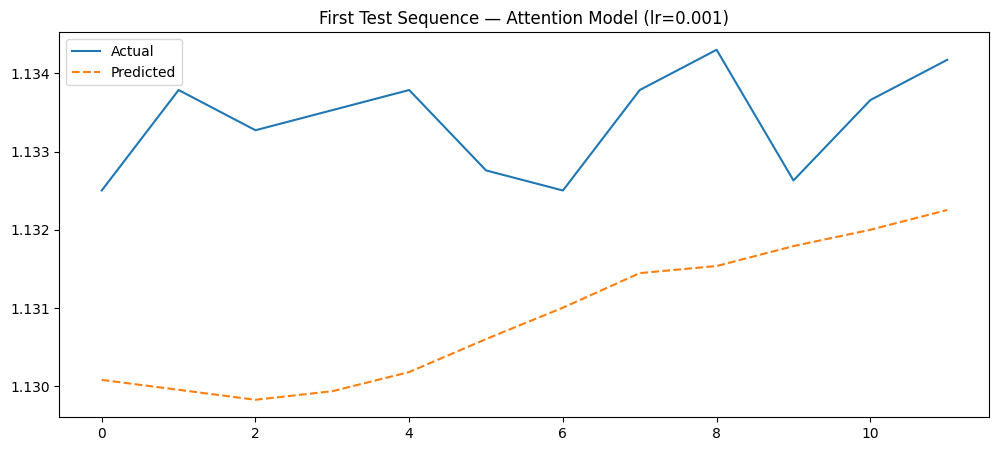

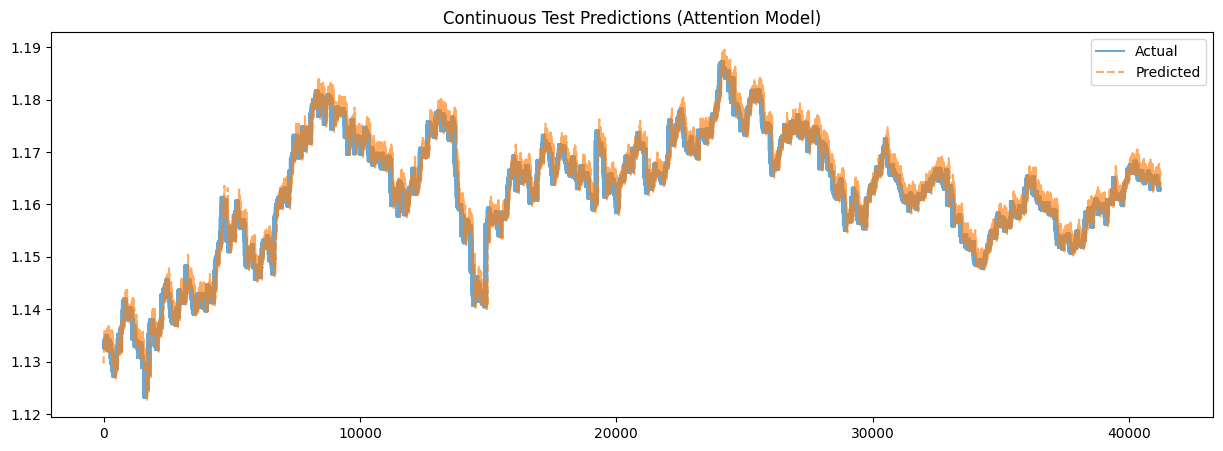

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Attention
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# ============================================================
# 1. LOAD DATA
# ============================================================
df = pd.read_csv("EURUSD=X_feature_data.csv", parse_dates=["Datetime"], index_col="Datetime")
df = df.drop("interest_rate_differential", axis=1)

# ============================================================
# 2. SAVE RAW CLOSE (never scale this)
# ============================================================
df["Close_raw"] = df["Close"].copy()

# ============================================================
# 3. LOG RETURNS (FORECAST HORIZON)
# ============================================================
FORECAST = 12
for i in range(1, FORECAST + 1):
    df[f"return_{i}h"] = np.log(df["Close"].shift(-i) / df["Close"])

df.dropna(inplace=True)

# ============================================================
# 4. FEATURES & TARGETS
# ============================================================
target_cols = [f"return_{i}h" for i in range(1, FORECAST + 1)]
feature_cols = [c for c in df.columns if c not in target_cols]

# Scale everything except Close_raw
scaler = StandardScaler()
features_to_scale = [c for c in feature_cols if c != "Close_raw"]
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# ============================================================
# 5. CREATE SEQUENCES
# ============================================================
LOOKBACK = 48

def create_sequences(features, targets, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i:i+lookback])
        y.append(targets[i+lookback])
    return np.array(X), np.array(y)

X, y = create_sequences(df[feature_cols].values, df[target_cols].values, LOOKBACK)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# ============================================================
# 6. ATTENTION MODEL BUILDER
# ============================================================
def build_attention_model(input_shape, lr):
    inp = Input(shape=input_shape)

    x = LSTM(128, return_sequences=True,
             dropout=0.3, recurrent_dropout=0.2,
             kernel_regularizer=l2(1e-4))(inp)

    # attention layer
    x = Attention()([x, x])

    x = LSTM(64, return_sequences=False,
             dropout=0.2, recurrent_dropout=0.1,
             kernel_regularizer=l2(1e-4))(x)

    x = Dense(32, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.2)(x)

    out = Dense(FORECAST)(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse")
    return model

# ============================================================
# 7. LEARNING RATE SWEEP
# ============================================================
learning_rates = [0.001]
results = {}

for lr in learning_rates:
    print(f"\n============================")
    print(f"Training Attention Model @ lr={lr}")
    print(f"============================\n")

    model = build_attention_model((LOOKBACK, X.shape[2]), lr)

    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=1
    )

    # predictions
    y_pred_log_returns = model.predict(X_test)
    num_sequences = len(y_pred_log_returns) - FORECAST + 1

    last_close = df["Close_raw"].values[
        split + LOOKBACK - 1 : split + LOOKBACK - 1 + num_sequences
    ]

    # reconstruct prices
    pred_prices = []
    for i in range(num_sequences):
        cum_returns = np.exp(np.cumsum(y_pred_log_returns[i]))
        prices = last_close[i] * cum_returns
        pred_prices.append(prices)
    pred_prices = np.array(pred_prices)

    actual_prices = np.array([
        df["Close_raw"].values[
            split + LOOKBACK + i : split + LOOKBACK + i + FORECAST
        ]
        for i in range(num_sequences)
    ])

    rmse = np.sqrt(np.mean((pred_prices - actual_prices)**2))
    print(f"Reconstructed Price RMSE (lr={lr}): {rmse:.6f}")

    results[lr] = {
        "model": model,
        "rmse": rmse,
        "pred_prices": pred_prices,
        "actual_prices": actual_prices
    }

# ============================================================
# 8. PLOT BEST MODEL
# ============================================================
best_lr = min(results, key=lambda lr: results[lr]["rmse"])
print(f"\nBest LR = {best_lr}  |  RMSE = {results[best_lr]['rmse']:.6f}")

pred_best = results[best_lr]["pred_prices"]
actual_best = results[best_lr]["actual_prices"]

plt.figure(figsize=(12,5))
plt.plot(actual_best[0], label="Actual")
plt.plot(pred_best[0], label="Predicted", linestyle="--")
plt.title(f"First Test Sequence — Attention Model (lr={best_lr})")
plt.legend()
plt.show()

# ============================================================
# 9. PLOT CONTINUOUS SERIES
# ============================================================
plt.figure(figsize=(15,5))
plt.plot(actual_best.flatten(), label="Actual", alpha=0.65)
plt.plot(pred_best.flatten(), label="Predicted", alpha=0.65, linestyle="--")
plt.title("Continuous Test Predictions (Attention Model)")
plt.legend()
plt.show()


## Model Fitting--Model Evaluation--Predictions--Trading Strategy-----v4

2025-12-15 13:15:21.059203: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 13:15:36.970631: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 13:15:45.776787: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


X shape: (17234, 48, 23)
y shape: (17234, 12)


2025-12-15 13:15:47.600754: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


2025-12-15 13:15:47.897865: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 48704064 exceeds 10% of free system memory.


345/345 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - loss: 0.0097 - val_loss: 0.0028
Epoch 2/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - loss: 0.0013 - val_loss: 4.6049e-04
Epoch 3/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - loss: 2.1575e-04 - val_loss: 8.7486e-05
Epoch 4/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 30s 86ms/step - loss: 4.3320e-05 - val_loss: 2.5058e-05
Epoch 5/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - loss: 1.2957e-05 - val_loss: 1.2971e-05
Epoch 6/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - loss: 6.7506e-06 - val_loss: 1.0267e-05
Epoch 7/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - loss: 5.3151e-06 - val_loss: 9.6466e-06
Epoch 8/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - loss: 4.9922e-06 - val_loss: 9.4750e-06
Epoch 9/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - loss: 4.9006e-06 - val_loss: 9.4441e-06
Epoch 10/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - loss: 4.8837e-06 - val_loss: 9.4267e-06
Epoch 11/50
345/345 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - loss:

2025-12-15 13:27:44.155569: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 15221952 exceeds 10% of free system memory.


108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
  9/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.1522e-06

2025-12-15 13:27:46.754430: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 15221952 exceeds 10% of free system memory.


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.6111e-06
Test MSE: 4.611138137988746e-06
📊 A11 — Strategy Performance with Dynamic Position Sizing
Trades taken: 131
Win rate: 52.67%
Average return per trade: 0.00008
Total return (test period): 0.0106


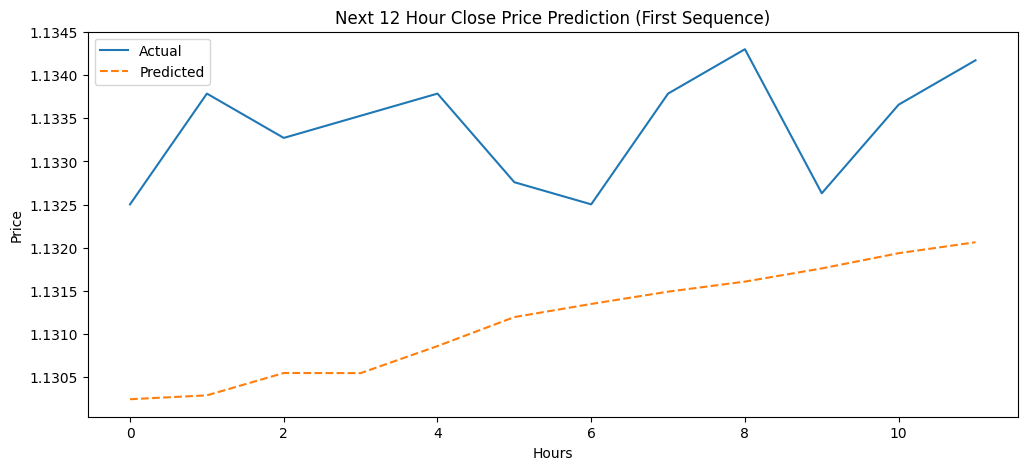

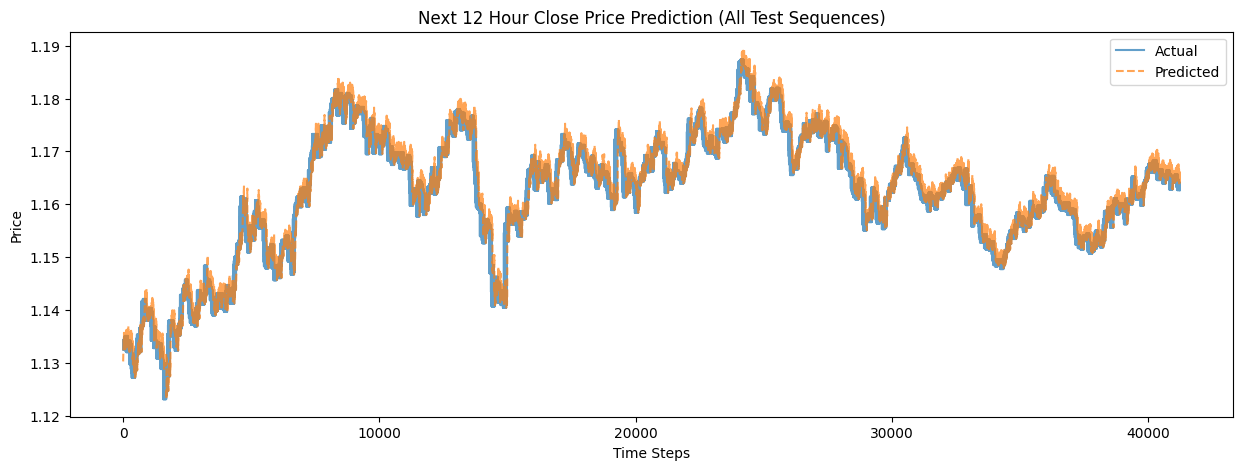

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# -------------------------
# 1. LOAD DATA
# -------------------------
df = pd.read_csv("EURUSD=X_feature_data.csv", parse_dates=["Datetime"], index_col="Datetime")
df = df.drop("interest_rate_differential", axis=1)  # currently has NaNs

# -------------------------
# 2. SAVE RAW CLOSE
# -------------------------
df["Close_raw"] = df["Close"].copy()

# -------------------------
# 3. COMPUTE LOG RETURNS
# -------------------------
FORECAST = 12  # predict next 12 returns
for i in range(1, FORECAST + 1):
    df[f"return_{i}h"] = np.log(df["Close"].shift(-i) / df["Close"])
df.dropna(inplace=True)

# -------------------------
# 4. FEATURES AND TARGETS
# -------------------------
target_cols = [f"return_{i}h" for i in range(1, FORECAST + 1)]
feature_cols = [c for c in df.columns if c not in target_cols]

# Scale features (do NOT scale returns or Close_raw!)
scaler = StandardScaler()
features_to_scale = [c for c in feature_cols if c != "Close_raw"]
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# -------------------------
# 5. CREATE SEQUENCES
# -------------------------
LOOKBACK = 48

def create_sequences(features, targets, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i:i+lookback])
        y.append(targets[i+lookback])
    return np.array(X), np.array(y)

X, y = create_sequences(df[feature_cols].values, df[target_cols].values, LOOKBACK)
print("X shape:", X.shape)
print("y shape:", y.shape)

# -------------------------
# 6. TRAIN/TEST SPLIT
# -------------------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------------
# 7. BUILD BEST LSTM MODEL
# -------------------------
best_lr = 0.001
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(LOOKBACK, X.shape[2]),
         dropout=0.3, recurrent_dropout=0.2, kernel_regularizer=l2(1e-4)),
    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=l2(1e-4)),
    Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(FORECAST)
])

optimizer = Adam(learning_rate=best_lr)
model.compile(optimizer=optimizer, loss="mse")

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# -------------------------
# 8. PREDICT LOG RETURNS
# -------------------------
y_pred_log_returns = model.predict(X_test)
test_loss = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss)

# -------------------------
# 9. RECONSTRUCT PRICES
# -------------------------
num_sequences = len(y_pred_log_returns) - FORECAST + 1
last_close = df["Close_raw"].values[split + LOOKBACK - 1 : split + LOOKBACK - 1 + num_sequences]

pred_prices = []
for i in range(num_sequences):
    cum_returns = np.exp(np.cumsum(y_pred_log_returns[i]))
    prices = last_close[i] * cum_returns
    pred_prices.append(prices)
pred_prices = np.array(pred_prices)

actual_prices = np.array([
    df["Close_raw"].values[split + LOOKBACK + i : split + LOOKBACK + i + FORECAST]
    for i in range(num_sequences)
])

# -------------------------
# 10. TRADING SIMULATION (DYNAMIC POSITION SIZING)
# -------------------------
threshold = 0.0030  # ~30 pips
pred_prices_flat = pred_prices.flatten()
actual_prices_flat = actual_prices.flatten()

pred_returns_flat = np.diff(pred_prices_flat) / pred_prices_flat[:-1]
actual_returns_flat = np.diff(actual_prices_flat) / actual_prices_flat[:-1]

pred_direction = np.sign(pred_returns_flat)
actual_direction = np.sign(actual_returns_flat)

# Only take trades above threshold
trade_mask = np.abs(pred_returns_flat) >= threshold
trades_taken = trade_mask.sum()

# Dynamic position sizing: proportional to predicted return magnitude
position_sizes = np.abs(pred_returns_flat[trade_mask]) / np.max(np.abs(pred_returns_flat[trade_mask]))

# Strategy returns with dynamic sizing
strategy_returns = actual_returns_flat[trade_mask] * pred_direction[trade_mask] * position_sizes
total_return = np.sum(strategy_returns)
avg_return = strategy_returns.mean() if trades_taken > 0 else np.nan
win_rate = (strategy_returns > 0).mean() if trades_taken > 0 else np.nan

print("📊 A11 — Strategy Performance with Dynamic Position Sizing")
print(f"Trades taken: {trades_taken}")
print(f"Win rate: {win_rate * 100:.2f}%")
print(f"Average return per trade: {avg_return:.5f}")
print(f"Total return (test period): {total_return:.4f}")

# -------------------------
# 11. PLOT FIRST SEQUENCE
# -------------------------
plt.figure(figsize=(12,5))
plt.plot(actual_prices[0], label="Actual")
plt.plot(pred_prices[0], label="Predicted", linestyle="--")
plt.title("Next 12 Hour Close Price Prediction (First Sequence)")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.legend()
plt.show()

# -------------------------
# 12. PLOT CONTINUOUS PREDICTIONS
# -------------------------
plt.figure(figsize=(15,5))
plt.plot(actual_prices_flat, label="Actual", alpha=0.7)
plt.plot(pred_prices_flat, label="Predicted", linestyle="--", alpha=0.7)
plt.title("Next 12 Hour Close Price Prediction (All Test Sequences)")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.show()


In [3]:
# -------------------------
# 10B. TRADING SIMULATION WITH COSTS & SLIPPAGE
# -------------------------
transaction_cost = 0.0002  # ~2 pips per trade
slippage_max = 0.0001      # max ±1 pip slippage

# Calculate raw predicted returns
pred_returns_flat = np.diff(pred_prices_flat) / pred_prices_flat[:-1]
actual_returns_flat = np.diff(actual_prices_flat) / actual_prices_flat[:-1]

pred_direction = np.sign(pred_returns_flat)
actual_direction = np.sign(actual_returns_flat)

# Only take trades above threshold
trade_mask = np.abs(pred_returns_flat) >= threshold
trades_taken = trade_mask.sum()

# Simulate slippage
np.random.seed(42)  # for reproducibility
slippage = np.random.uniform(-slippage_max, slippage_max, size=trades_taken)

# Compute net returns per trade
strategy_returns = actual_returns_flat[trade_mask] * pred_direction[trade_mask]
strategy_returns_net = strategy_returns - transaction_cost + slippage

# Performance metrics
total_return_net = np.sum(strategy_returns_net)
avg_return_net = strategy_returns_net.mean() if trades_taken > 0 else np.nan
win_rate_net = (strategy_returns_net > 0).mean() if trades_taken > 0 else np.nan

print("📊 A12 — Strategy Performance with Costs & Slippage")
print(f"Trades taken: {trades_taken}")
print(f"Win rate: {win_rate_net * 100:.2f}%")
print(f"Average return per trade (net): {avg_return_net:.5f}")
print(f"Total return (test period, net): {total_return_net:.4f}")


📊 A12 — Strategy Performance with Costs & Slippage
Trades taken: 131
Win rate: 49.62%
Average return per trade (net): 0.00005
Total return (test period, net): 0.0064


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# -------------------------
# 1. LOAD DATA
# -------------------------
df = pd.read_csv("EURUSD=X_feature_data.csv", parse_dates=["Datetime"], index_col="Datetime")
df = df.drop("interest_rate_differential", axis=1)  # currently has NaNs

# -------------------------
# 2. SAVE RAW CLOSE
# -------------------------
df["Close_raw"] = df["Close"].copy()

# -------------------------
# 3. COMPUTE LOG RETURNS
# -------------------------
FORECAST = 12  # predict next 12 returns
for i in range(1, FORECAST + 1):
    df[f"return_{i}h"] = np.log(df["Close"].shift(-i) / df["Close"])
df.dropna(inplace=True)

# -------------------------
# 4. FEATURES AND TARGETS
# -------------------------
target_cols = [f"return_{i}h" for i in range(1, FORECAST + 1)]
feature_cols = [c for c in df.columns if c not in target_cols]

scaler = StandardScaler()
features_to_scale = [c for c in feature_cols if c != "Close_raw"]
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# -------------------------
# 5. CREATE SEQUENCES
# -------------------------
LOOKBACK = 48

def create_sequences(features, targets, lookback):
    X, y = [], []
    for i in range(len(features) - lookback):
        X.append(features[i:i+lookback])
        y.append(targets[i+lookback])
    return np.array(X), np.array(y)

X, y = create_sequences(df[feature_cols].values, df[target_cols].values, LOOKBACK)
print("X shape:", X.shape, "y shape:", y.shape)

# -------------------------
# 6. WALK-FORWARD SPLIT PARAMETERS
# -------------------------
n_splits = 5
split_size = X.shape[0] // (n_splits + 1)

walk_results = []

for split_idx in range(n_splits):
    train_end = split_size * (split_idx + 1)
    test_start = train_end
    test_end = test_start + split_size
    
    X_train, y_train = X[:train_end], y[:train_end]
    X_test, y_test = X[test_start:test_end], y[test_start:test_end]
    
    # -------------------------
    # 7. BUILD MODEL
    # -------------------------
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(LOOKBACK, X.shape[2]),
             dropout=0.3, recurrent_dropout=0.2, kernel_regularizer=l2(1e-4)),
        LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=l2(1e-4)),
        Dense(32, activation="relu", kernel_regularizer=l2(1e-4)),
        Dropout(0.2),
        Dense(FORECAST)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    
    es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
    model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[es], verbose=0)
    
    # -------------------------
    # 8. PREDICT & RECONSTRUCT PRICES
    # -------------------------
    y_pred = model.predict(X_test)
    last_close = df["Close_raw"].values[test_start + LOOKBACK - 1 : test_end + LOOKBACK - 1]
    
    pred_prices, actual_prices = [], []
    for i in range(len(y_pred)):
        cum_returns = np.exp(np.cumsum(y_pred[i]))
        pred_prices.append(last_close[i] * cum_returns)
        actual_prices.append(df["Close_raw"].values[test_start + LOOKBACK + i : test_start + LOOKBACK + i + FORECAST])
    
    pred_prices = np.array(pred_prices)
    actual_prices = np.array(actual_prices)
    
    # RMSE
    rmse = np.sqrt(np.mean((pred_prices - actual_prices)**2))
    
    # -------------------------
    # 9. SIMPLE THRESHOLD STRATEGY
    # -------------------------
    pred_flat = pred_prices.flatten()
    actual_flat = actual_prices.flatten()
    
    pred_returns = np.diff(pred_flat) / pred_flat[:-1]
    actual_returns = np.diff(actual_flat) / actual_flat[:-1]
    
    trade_mask = np.abs(pred_returns) >= 0.003  # 30 pips
    trades_taken = trade_mask.sum()
    
    strategy_returns = actual_returns[trade_mask] * np.sign(pred_returns[trade_mask])
    total_return = np.sum(strategy_returns)
    avg_return = strategy_returns.mean() if trades_taken > 0 else np.nan
    win_rate = (strategy_returns > 0).mean() if trades_taken > 0 else np.nan
    
    walk_results.append({
        "rmse": rmse,
        "trades": trades_taken,
        "win_rate": win_rate,
        "avg_return": avg_return,
        "total_return": total_return
    })
    
    # -------------------------
    # 10. PLOT FIRST 3 SEQUENCES
    # -------------------------
    plt.figure(figsize=(12,5))
    for seq in range(min(3, len(pred_prices))):
        plt.plot(actual_prices[seq], label=f"Actual Seq {seq+1}")
        plt.plot(pred_prices[seq], linestyle="--", label=f"Predicted Seq {seq+1}")
    plt.title(f"Walk-Forward Split {split_idx+1}: First 3 Sequences")
    plt.xlabel("Hours")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# -------------------------
# 11. REPORT AGGREGATED RESULTS
# -------------------------
rmse_all = [r["rmse"] for r in walk_results]
trades_all = [r["trades"] for r in walk_results]
win_all = [r["win_rate"] for r in walk_results if not np.isnan(r["win_rate"])]
avg_return_all = [r["avg_return"] for r in walk_results if not np.isnan(r["avg_return"])]
total_return_all = [r["total_return"] for r in walk_results]

print("📊 A17 — Walk-Forward Results")
print(f"Average RMSE: {np.mean(rmse_all):.6f}")
print(f"Average trades per split: {np.mean(trades_all):.2f}")
print(f"Average win rate: {np.mean(win_all)*100:.2f}%")
print(f"Average return per trade: {np.mean(avg_return_all):.5f}")
print(f"Average total return per split: {np.mean(total_return_all):.4f}")
